# Change in liquid precipitation

Recreates Figure 11 from paper that shows change in liquid precipitation between the periods 1979 to 1989 and 2013 to 2023.

In [1]:
from typing import List

import calendar
import itertools
import warnings

import xarray as xr
from xarray.groupers import SeasonResampler, SeasonGrouper
import cf_xarray.units
import pint_xarray

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib as mpl
import matplotlib.colors as mcolors

import cartopy.crs as ccrs

PRECIP_DATA = "../../data/data_stream-moda_stepType-avgad.nc"

PROJECTION = ccrs.Orthographic(central_latitude=90.)

## Load data

Data were obtained from the WekEO site.  If data have not been downloaded, run `src\get_data.py`.  

I use `pint-xarray` and `cf-xarray` packages to make the dataset unit aware.

In [2]:
ds = xr.open_dataset(
    PRECIP_DATA, 
    drop_variables=["number","expver"]
).pint.quantify(
    {
        "tp": "meters",
        "sf": "meters",  # Need to do this because m water equivalent is not valid unit
    }
)
ds

<xarray.Dataset> Size: 753MB
Dimensions:     (valid_time: 540, latitude: 121, longitude: 1440)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 4kB 1979-01-01T06:00:00 ... 2023-...
  * latitude    (latitude) float64 968B [degrees_north] 90.0 89.75 ... 60.0
  * longitude   (longitude) float64 12kB [degrees_east] -180.0 -179.8 ... 179.8
Data variables:
    tp          (valid_time, latitude, longitude) float32 376MB [m] 0.0002937...
    sf          (valid_time, latitude, longitude) float32 376MB [m] 0.0002923...
Indexes:
    latitude   PintIndex(PandasIndex, units={'latitude': 'degrees_north'})
    longitude  PintIndex(PandasIndex, units={'longitude': 'degrees_east'})
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-30T18:16 GRIB to CDM+CF via cfgrib-0.9.1...

## Calculate liquid precipitation

Liquid precipitation is calculated as the difference between total precipitation (`tp`) and snowfall (`sf`).

_Zaria does not "clip" negative values but I do here.  This code should be extracted and the precipitation file written to file._ 

**The `lp` values match those values in `LiquidPrecip.ipynb` for the same calculation.**

In [3]:
ds['lp'] = (ds.tp - ds.sf).clip(min=0.)
ds.lp.attrs = {
    'long_name': 'liquid precipitation',
    'units': ds.lp.pint.units,
}
ds

<xarray.Dataset> Size: 1GB
Dimensions:     (valid_time: 540, latitude: 121, longitude: 1440)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 4kB 1979-01-01T06:00:00 ... 2023-...
  * latitude    (latitude) float64 968B [degrees_north] 90.0 89.75 ... 60.0
  * longitude   (longitude) float64 12kB [degrees_east] -180.0 -179.8 ... 179.8
Data variables:
    tp          (valid_time, latitude, longitude) float32 376MB [m] 0.0002937...
    sf          (valid_time, latitude, longitude) float32 376MB [m] 0.0002923...
    lp          (valid_time, latitude, longitude) float32 376MB [m] 1.431e-06...
Indexes:
    latitude   PintIndex(PandasIndex, units={'latitude': 'degrees_north'})
    longitude  PintIndex(PandasIndex, units={'longitude': 'degrees_east'})
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-30T18:16 GRIB to CDM+CF via cfgrib-0.9.1...

Note: monthly means of accumulated variables are scaled to have units _m per day_.  See [ERA5 knowledge base](https://confluence.ecmwf.int/pages/viewpage.action?pageId=197702790).  

In `LiquidPrecip.ipynb`, average annual fields appear to be calculated as long-term averages of monthly fields.  Data fields also appear to be scaled by `1000 * 1000` to convert from meters to millimeters. For example:

```
# Multiply the data by 1000 to convert from meters to millimeters
    data_mm = data * 1000 * 1000

# Plot data
pp = ax.pcolormesh(data_mm.longitude, data_mm.latitude, data_mm.mean(dim='date'),
                   cmap=cmap, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
```

## Convert to monthly totals in millimeters

I convert fields from monthly average daily precipitation in m/day to monthly accumulated precipitation in mm.  The conversion from average daily precipitation to month accumulated precipitation is done by multiplying each month by the number of days in that month.

Because the Dataset is unit-aware, `pint` can be used to convert the data variables from meters to millimeters.

In [4]:
xr.set_options(keep_attrs=True)
ds_mon = ds * ds.valid_time.dt.days_in_month
ds_mon = ds_mon.pint.to(
    {
        "tp": "millimeters",
        "sf": "millimeters",
        "lp": "millimeters",
    },
)

## Calculate annual accumulated precipitation

This can be done in a number of ways.  Here, because data variables in `ds_mon` are monthly accumulations of precipitation, monthly fields can be summed for each year to get an annual accumulation of precipitation.

`xarray.Dataset.resample` is used to do this.

In [5]:
ds_ann = ds_mon.resample(valid_time="YS").sum()
ds_ann

<xarray.Dataset> Size: 188MB
Dimensions:     (valid_time: 45, latitude: 121, longitude: 1440)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 360B 1979-01-01 ... 2023-01-01
  * latitude    (latitude) float64 968B [degrees_north] 90.0 89.75 ... 60.0
  * longitude   (longitude) float64 12kB [degrees_east] -180.0 -179.8 ... 179.8
Data variables:
    tp          (valid_time, latitude, longitude) float64 63MB [mm] 222.5 ......
    sf          (valid_time, latitude, longitude) float64 63MB [mm] 179.5 ......
    lp          (valid_time, latitude, longitude) float64 63MB [mm] 43.07 ......
Indexes:
    latitude   PintIndex(PandasIndex, units={'latitude': 'degrees_north'})
    longitude  PintIndex(PandasIndex, units={'longitude': 'degrees_east'})
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-30T18:16 GRIB to CDM+CF via cfgrib-0.9.1...

## Calculate ratio of liquid precipitation to total precipitation for annual accumulations

In [6]:
ds_ann["lp_tp"] = ds_ann.lp / ds_ann.tp
ds_ann.lp_tp.attrs = {
    "long_name": "Liquid precipitation as fraction of total precipitation",
    "units": 1,
}

## Calculate Seasonal Accumulated Precipitation

In [7]:
ds_ssn = ds_mon.resample(
    valid_time=SeasonResampler(["DJF", "MAM", "JJA", "SON"])
).sum(keep_attrs=True)

# Calculate liquid precipitation as fraction of total precipitation
ds_ssn["lp_tp"] = ds_ssn.lp / ds_ssn.tp
ds_ssn.lp_tp.attrs = {
    "long_name": "Liquid precipitation as fraction of total precipitation",
    "units": 1,
}

ds_ssn

<xarray.Dataset> Size: 998MB
Dimensions:     (valid_time: 179, latitude: 121, longitude: 1440)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 1kB 1979-03-01 ... 2023-09-01
  * latitude    (latitude) float64 968B [degrees_north] 90.0 89.75 ... 60.0
  * longitude   (longitude) float64 12kB [degrees_east] -180.0 -179.8 ... 179.8
Data variables:
    tp          (valid_time, latitude, longitude) float64 250MB [mm] 26.77 .....
    sf          (valid_time, latitude, longitude) float64 250MB [mm] 26.69 .....
    lp          (valid_time, latitude, longitude) float64 250MB [mm] 0.08869 ...
    lp_tp       (valid_time, latitude, longitude) float64 250MB [] 0.003314 ....
Indexes:
    latitude   PintIndex(PandasIndex, units={'latitude': 'degrees_north'})
    longitude  PintIndex(PandasIndex, units={'longitude': 'degrees_east'})
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-30T18:16 GRIB to CDM+CF via cfgrib-0.9.1...

In [8]:
ds_ssn_clm = ds_ssn.groupby("valid_time.month").mean()
ds_ssn_clm = ds_ssn_clm.rename({"month": "season"})
ds_ssn_clm["season"] = ["MAM", "JJA", "SON", "DJF"]
ds_ssn_clm

Magnitude,[90.0 89.75 89.5 89.25 89.0 88.75 88.5 88.25 88.0 87.75 87.5 87.25 87.0 86.75 86.5 86.25 86.0 85.75 85.5 85.25 85.0 84.75 84.5 84.25 84.0 83.75 83.5 83.25 83.0 82.75 82.5 82.25 82.0 81.75 81.5 81.25 81.0 80.75 80.5 80.25 80.0 79.75 79.5 79.25 79.0 78.75 78.5 78.25 78.0 77.75 77.5 77.25 77.0 76.75 76.5 76.25 76.0 75.75 75.5 75.25 75.0 74.75 74.5 74.25 74.0 73.75 73.5 73.25 73.0 72.75 72.5 72.25 72.0 71.75 71.5 71.25 71.0 70.75 70.5 70.25 70.0 69.75 69.5 69.25 69.0 68.75 68.5 68.25 68.0 67.75 67.5 67.25 67.0 66.75 66.5 66.25 66.0 65.75 65.5 65.25 65.0 64.75 64.5 64.25 64.0 63.75 63.5 63.25 63.0 62.75 62.5 62.25 62.0 61.75 61.5 61.25 61.0 60.75 60.5 60.25 60.0]
Units,degrees_north
Magnitude,[-180.0 -179.75 -179.5 ... 179.25 179.5 179.75]
Units,degrees_east
Magnitude,[[[45.35128275553385 45.35128275553385 45.35128275553385 ... 45.35128275553385 45.35128275553385 45.35128275553385] [44.743643866644966 44.739744398328995 44.734488593207466 ... 44.754134284125435 44.752163357204864 44.747585720486114] [45.0020260281033 44.98553805881076 44.97903188069662 ... 45.03084818522135 45.026863945855034 45.01707288953993] ... [154.30338117811414 152.6267793443468 150.97041659884982 ... 159.43380991617838 157.7405505710178 156.03904724121094] [160.39439307318793 158.63412221272787 156.93405999077692 ... 165.10401831732855 163.6402553982205 162.1222390068902] [167.17444525824652 165.35828908284506 163.4913126627604 ... 170.8926518758138 169.9601067437066 168.9639197455512]] [[96.81684705946181 96.81684705946181 96.81684705946181 ... 96.81684705946181 96.81684705946181 96.81684705946181] [96.67074415418837 96.660402086046 96.66171603732639 ... 96.68210347493489 96.68091668023004 96.67833116319444] [97.59538438585069 97.58631388346355 97.5748274061415 ... 97.63853285047743 97.61928982204861 97.61691623263889] ... [150.84520975748697 150.91031392415366 150.96753438313803 ... 149.77887471516928 149.81443617078992 150.39075215657553] [150.9993659125434 151.16742451985678 151.47887335883246 ... 151.05790032280817 150.98872714572482 150.92667473687067] [152.54423353407117 153.25067308213977 153.50057813856336 ... 152.2261725531684 152.00992160373264 151.83902316623264]] [[74.48101043701172 74.48101043701172 74.48101043701172 ... 74.48101043701172 74.48101043701172 74.48101043701172] [74.46255154079861 74.46115281846788 74.46051703559027 ... 74.46956634521484 74.46390787760417 74.45873684353299] [74.84891679551866 74.84124501546223 74.83291625976562 ... 74.86055162217882 74.85724555121527 74.84760284423828] ... [275.28343200683594 273.53214687771265 271.6322792900933 ... 275.7293701171875 275.5539788140191 275.5746841430664] [277.6476542154948 276.87166002061633 275.6579293145074 ... 278.2762951321072 278.62220340304907 278.857782151964] [279.61824205186633 280.92322879367407 280.173577202691 ... 277.502081129286 277.87712944878473 278.32614050971137]] [[40.559595281427555 40.559595281427555 40.559595281427555 ... 40.559595281427555 40.559595281427555 40.559595281427555] [39.76063294844194 39.761239832097836 39.758140390569515 ... 39.76609490134499 39.76670178500089 39.76206345991655] [39.00913758711381 39.00853070345792 39.006059820001774 ... 39.01897777210582 39.01655023748224 39.01117498224432] ... [277.22738005898213 275.6062854420055 273.7630930813876 ... 278.7475369193337 278.0501409010454 277.7239192615856] [282.5862927870317 281.6590179096569 278.8207530975342 ... 284.31621464816004 284.02800993485886 283.63221341913396] [287.5264341180975 287.2131954539906 285.13925725763494 ... 285.78300909562546 286.8466377258301 287.8213579004461]]]
Units,millimeter
Magnitude,[[[45.22297117445204 45.22297117445204 45.22297117445204 ... 45.22297117445204 45.22297117445204 45.22297117445204] [44.63329315185547 44.628026750352646 44.626877042982315 ... 44.64169078403049 44.640541076660156 44.63655683729384] [44.88185246785482 44.875786039564346 44.86740960015191 ... 44.90229288736979 44.8940806918674 44.888104332817925] ... [120.94414499070909 119.71

## Plotting tools

In [9]:
def plot_boundary(ax: plt.Axes):
    """Set circular boundary for the polar projection"""
    theta = np.linspace(0, 2 * np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)


def plot_map(da: xr.DataArray,
             ax: plt.Axes=None,
             contours: List=[],
             title: str=None,
             projection: ccrs.Projection=None,
             **kwargs,
             ):
    """Basic plotting routine for all figures.  Produces a single plot panel.

    Arguments
    ---------
    da : 2D xarray.DataArray containing field to be plotted.
    ax : GeoAxes object created using plt.subplots or fig.add_subplot
    countours : list of contour intervals.  If empty no contours are drawn - default
    title : plot title
    projection : cartopy.crs.Projection.  Default is polar orthographic projection
    **kwargs : dictionary containing keywords to be passed to pcolormesh

    Returns:
    None
    """

    extent = [-180., 180., 66.5, 90]

    if not projection:
        projection = ccrs.Orthographic(central_latitude=90.)
        
    if not ax:
        fig = plt.gcf()
        ax = fig.add_subplot(projection=projection)
        
    # da.plot(
    #     ax=ax,
    #     transform=ccrs.PlateCarree(),
    #     **kwargs,
    # )

    if "cbar_kwargs" in kwargs:
        cbar_kwargs = kwargs["cbar_kwargs"]
        kwargs = {k: v for k, v in kwargs.items() if k != "cbar_kwargs"}

    if "add_colorbar" in kwargs:
        add_colorbar = kwargs["add_colorbar"]
        kwargs = {k: v for k, v in kwargs.items() if k != "add_colorbar"}
    else:
        add_colorbar = True
        
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        mp = ax.pcolormesh(
            da.longitude,
            da.latitude,
            da,
            transform=ccrs.PlateCarree(),
            **kwargs,
            )

    if len(contours) > 0:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            ax.contour(
                da.longitude, 
                da.latitude, 
                da,
                levels=contours, 
                linewidths=0.6, 
                colors='black', 
                transform=ccrs.PlateCarree(),
                )
        # da.plot.contour(ax=ax, levels=contours, colors="k", zorder=3)
            
    plot_boundary(ax)
    
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.coastlines()

    if add_colorbar:
        plt.colorbar(mp, ax=ax, **cbar_kwargs)
    
    if title:
        ax.set_title(title)

### Plot average annual precipitation following Zaria's code

Here, I follow Zaria's code to calculate average annual precipitation.  This is calculated as a straight mean of monthly precipitation, which itself is expressed as a daily average.  The mean is also mutliplied by $10^6$.  This should be $10^3$ but the figures match what is shown in `LiquidPrecip.ipynb` and Figure 3 in the paper.

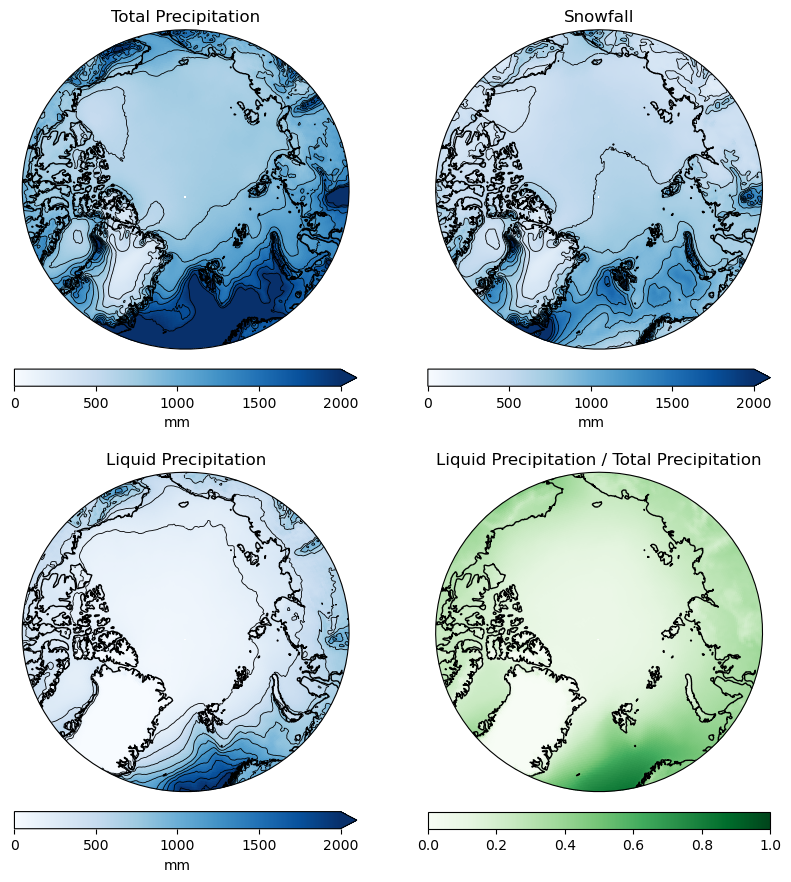

In [10]:
ds["lp_tp"] = ds.lp / ds.tp
ds.lp_tp.attrs["long_name"] = "Liquid Precipitation / Total Precipitation"
ds.lp.attrs["units"] = ""

fig, axes = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(9,9),
    subplot_kw=dict(projection=PROJECTION),
)

plot_map(
    ds.tp.mean(dim="valid_time")*1000.*1000., 
    ax=axes[0,0],
    contours=np.arange(0,2001,200),
    cmap="Blues", 
    vmin=0, vmax=2000.,
    cbar_kwargs=dict(orientation="horizontal", pad=0.05, label="mm", shrink=0.75, extend="max"),
    title="Total Precipitation"
)

plot_map(
    ds.sf.mean(dim="valid_time")*1000.*1000., 
    ax=axes[0,1],
    contours=np.arange(0,2001,200),
    cmap="Blues", 
    vmin=0, vmax=2000.,
    cbar_kwargs=dict(orientation="horizontal", pad=0.05, label="mm", shrink=0.75, extend="max"),
    title="Snowfall"
)

plot_map(
    ds.lp.mean(dim="valid_time")*1000.*1000., 
    ax=axes[1,0],
    contours=np.arange(0,2001,200),
    cmap="Blues", 
    vmin=0, vmax=2000.,
    cbar_kwargs=dict(orientation="horizontal", pad=0.05, label="mm", shrink=0.75, extend="max"),
    title="Liquid Precipitation"
)

plot_map(
    ds.lp_tp.mean(dim="valid_time"), 
    ax=axes[1,1],
    contours=np.arange(0,2001,200),
    cmap="Greens", 
    vmin=0, vmax=1.,
    cbar_kwargs=dict(orientation="horizontal", pad=0.05, label="", shrink=0.75),
    title="Liquid Precipitation / Total Precipitation"
)

fig.tight_layout()

## Plot average annual precipitation using `ds_ann`

IMO this is the correct way to calculate annual precipitation

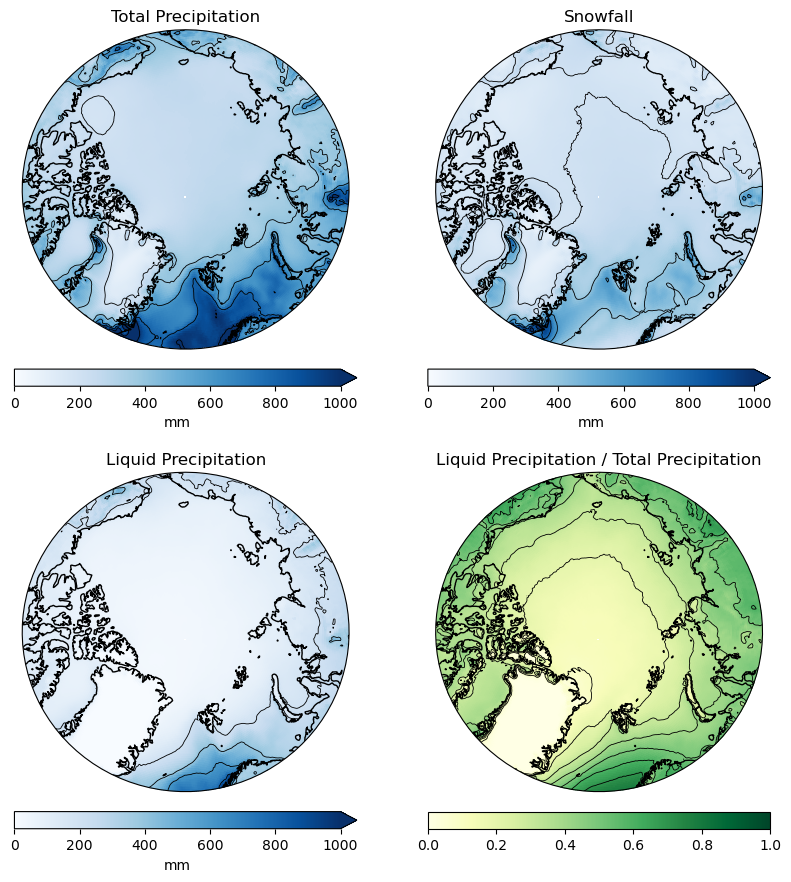

In [11]:
# Calculate average annual accumulated precipitation and convert to millimeters
ds_ann_clm = ds_ann.mean(dim="valid_time")

# Max and min in millimeters
vmin = 0
vmax = 1000

fig, axes = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(9,9),
    subplot_kw=dict(projection=PROJECTION),
)

plot_map(
    ds_ann_clm.tp, 
    ax=axes[0,0],
    contours=np.arange(vmin,vmax+1,200),
    cmap="Blues", 
    vmin=vmin, vmax=vmax,
    cbar_kwargs=dict(orientation="horizontal", pad=0.05, label="mm", shrink=0.75, extend="max"),
    title="Total Precipitation"
)

plot_map(
    ds_ann_clm.sf, 
    ax=axes[0,1],
    contours=np.arange(vmin,vmax+1,200),
    cmap="Blues", 
    vmin=vmin, vmax=vmax,
    cbar_kwargs=dict(orientation="horizontal", pad=0.05, label="mm", shrink=0.75, extend="max"),
    title="Snowfall"
)

plot_map(
    ds_ann_clm.lp, 
    ax=axes[1,0],
    contours=np.arange(vmin,vmax+1,200),
    cmap="Blues", 
    vmin=vmin, vmax=vmax,
    cbar_kwargs=dict(orientation="horizontal", pad=0.05, label="mm", shrink=0.75, extend="max"),
    title="Liquid Precipitation"
)

plot_map(
    ds_ann_clm.lp_tp, 
    ax=axes[1,1],
    contours=np.arange(0,1.1,0.1),
    cmap="YlGn", 
    vmin=0, vmax=1,
    cbar_kwargs=dict(orientation="horizontal", pad=0.05, label="", shrink=0.75),
    title="Liquid Precipitation / Total Precipitation"
)

fig.tight_layout()

## Seasonal Totals (Figure 4)

I've recalculated the seasonal totals used in Figure 4.  The range of values is 0 to 300 mm.  The original Figure 4 (repoduced above) has an upper bound on the colorbar of 2000 mm.  In many of the panels, the colours are saturated, even at this level. This seems unreasonable, especially as the upper bound for the annual totals is also 2000 mm.

I've set the contour levels to be every 50 mm between 0 and 300 mm.  Change `vmin`, `vmax` and `cint` to modify the contour levels.

I have also stuck with three-letter season names.  You can change the values in the `season_label` `dict` to modify these. 

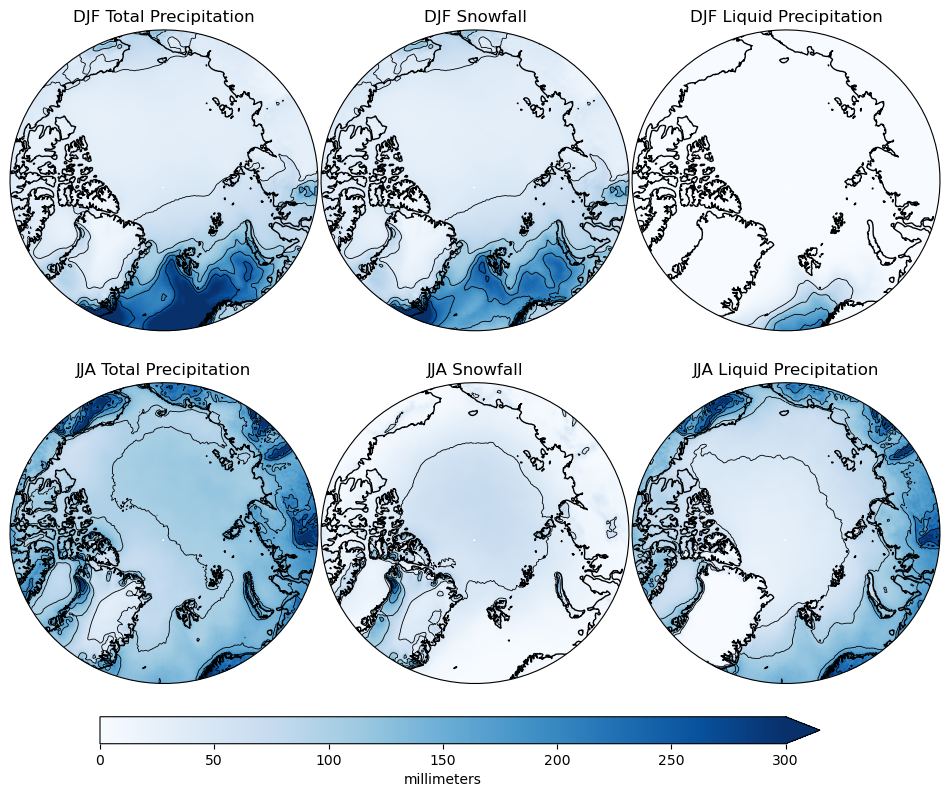

In [12]:
fig, axes = plt.subplots(
    nrows=2, 
    ncols=3, 
    figsize=(12,9),
    subplot_kw=dict(projection=PROJECTION)
)

vmin = 0
vmax = 300
cint = 50
cmap = "Blues"
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

season_label = {
    "DJF": "January",
    "MAM": "April",
    "JJA": "July",
    "SON": "October"
}

for ax, (season, var) in zip(axes.flatten(), itertools.product(["DJF", "JJA"], ["tp", "sf", "lp"])):
    # season_str = season_label[season]  # Uncomment this line to label with middle month
    season_str = season  # and comment this line
    
    plot_map(
        ds_ssn_clm[var].sel(season=season),
        ax=ax,
        contours=np.arange(vmin,vmax,cint),
        cmap=cmap,
        norm=norm,
        add_colorbar=False,
        title=f"{season_str} {ds_ssn_clm[var].attrs["long_name"].title()}"
)

fig.subplots_adjust(bottom=0.1, hspace=0.01, wspace=0.01)
cax = fig.add_axes((0.2, 0.06, 0.6, 0.03))
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), 
             cax=cax, orientation="horizontal", 
             label="millimeters", extend="max")


## Mean Seasonal Liquid Precipitation as a Fraction of Total Precipitation (Figure 6)

_How does Zaria do this?_  

I haven't had time to look into this.  But it makes the most sense to me to calculate the `lp`/`tp` ratio for each season and take the mean.

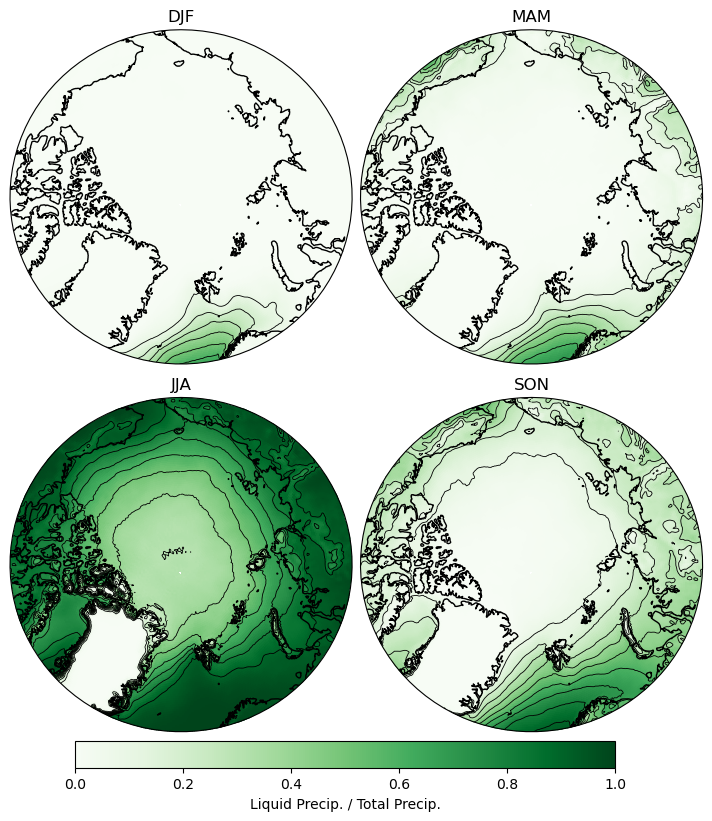

In [13]:
fig, axes = plt.subplots(
    nrows=2, 
    ncols=2, 
    figsize=(9,9),
    subplot_kw=dict(projection=PROJECTION)
)

vmin = 0
vmax = 1
cmap = "Greens"
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

for ax, season in zip(axes.flatten(), ["DJF", "MAM", "JJA", "SON"]):
    plot_map(
        ds_ssn_clm.lp_tp.sel(season=season),
        ax=ax,
        contours=np.arange(0,1.1,0.1),
        cmap=cmap,
        norm=norm,
        add_colorbar=False,
        title=f"{season}"
)

fig.subplots_adjust(bottom=0.1, hspace=0.1, wspace=0.01)
cax = fig.add_axes((0.2, 0.06, 0.6, 0.03))
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), 
             cax=cax, orientation="horizontal", 
             label="Liquid Precip. / Total Precip.", extend="neither")


## Trend in annual accumulations of precipitation (Figure 10)

I use `scipy.stats.linregress` with xarray's `apply_ufunc` to calculate trends in annual accumulated precipitation.  The `linear_trend` function returns an `xarray.Dataset` containing slope, intercept, r-value, p-value and standard error for the estimate slope.

In [14]:
from scipy.stats import linregress

def _linear_trend(x, y):
    """Helper function passed to apply_ufunc

    Arguments
    ---------
    x : x variable for regression
    y : y (dependent) variable for regression

    Returns
    -------
    numpy.Array containing regression parameters and 
    statistics

    See: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html
    """
    b1, b0, r, p, se = linregress(x, y)
    return np.array([b1, b0, r, p, se])

    
def linear_trend(da, dim="time"):
    """Calculate linear trend over dim.

    Arguments
    ---------
    da : 3-D time series of fields over which to calculate trend.
    dim : dimension over which to calculate trend.  Default is "time"

    Returns
    -------
    xarray.Dataset containing DataArrays for slope, intercept, r-value,
    p-value, and standard error of estimate slope.
    """
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        results = xr.apply_ufunc(
            _linear_trend,
            da[dim].dt.year,
            da,
            input_core_dims=[[dim], [dim]],
            output_core_dims=[['results']],
            vectorize=True,
            dask="parallelized",
            )
    return xr.Dataset(
        {
            "slope": xr.DataArray(
                results.isel(results=0),
                attrs = {
                    "long_name": "slope",
                    "units": "mm / year",
                },
            ),
            "intercept": xr.DataArray(
                results.isel(results=1),
                attrs = {
                    "long_name": "intercept",
                    "units": "mm",
                }
            ),
            "rvalue": xr.DataArray(
                results.isel(results=2),
                attrs = {
                    "long_name": "Pearson correlation coefficient",
                    "units": 1,
                }
            ),
            "pvalue": xr.DataArray(
                results.isel(results=3),
                attrs = {
                    "long_name": "P-value of hypothesis test",
                    "units": 1,
                }
            ),
            "stderr": xr.DataArray(
                results.isel(results=4),
                attrs = {
                    "long_name": "standard error of estimated slope",
                    "units": "mm / year",
                }
            ),
        },
        attrs = {"name": da.long_name}
    )
    
tp_trend = linear_trend(ds_ann.tp, dim="valid_time")
sf_trend = linear_trend(ds_ann.sf, dim="valid_time")
lp_trend = linear_trend(ds_ann.lp, dim="valid_time")

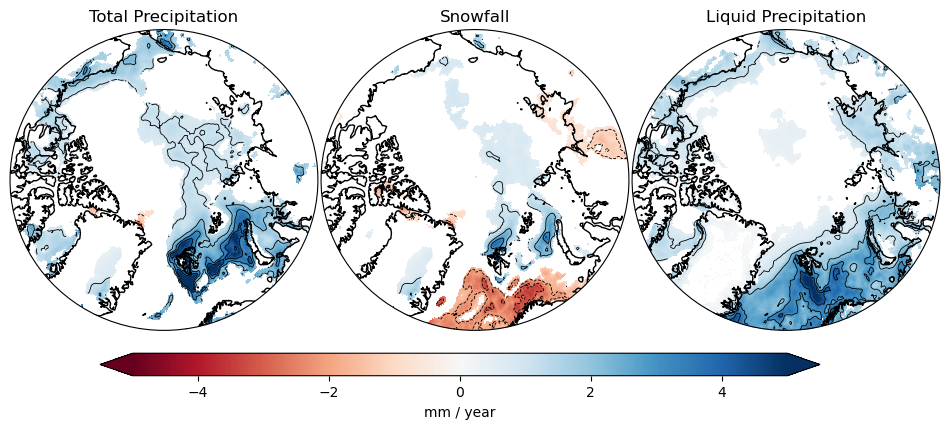

In [15]:
alpha = 0.05

vmin = -5.
vmax = 5.
cmap = "RdBu"
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

fig, axes = plt.subplots(
    nrows=1, 
    ncols=3, 
    figsize=(12,4.5),
    subplot_kw=dict(projection=PROJECTION)
)

for ax, dstrend in zip(axes, [tp_trend, sf_trend, lp_trend]):
    plot_map(
        dstrend.slope.where(dstrend.pvalue < alpha),
        ax=ax,
        contours=np.arange(vmin,vmax,1.0),
        cmap="RdBu",
        norm=norm,
        add_colorbar=False,
        title = dstrend.name.title()
        )

fig.subplots_adjust(bottom=0.05, wspace=0.01)
cax = fig.add_axes((0.2, 0.03, 0.6, 0.05))
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), 
             cax=cax, orientation="horizontal", 
             label="mm / year", extend="both")


## Calculate difference in mean annual accumulated precipitation for each phase between 1979 to 1988 and 2014 to 2023 (Figure 11)

Zaria's code from `LiquidPrecip.ipynb` calculate the difference in precipitation using the following code.

```
# Selecting the data for the first and last decades
first_decade = liquid_precip.sel(date=slice('1979-01-01', '1989-12-31'))
last_decade = liquid_precip.sel(date=slice('2013-01-01', '2023-12-31'))

# Compute the mean liquid precipitation for each decade
first_decade_mean = first_decade.mean(dim='date')
last_decade_mean = last_decade.mean(dim='date')

# Calculate the difference between the last and first decade and multiply by 1000
lp_difference = (last_decade_mean - first_decade_mean) * 1000  # Converts to mm if data is in meters
```

The first thing to note is that the "decades" are 11 years and not 10.  However, I don't think this will make a big difference in the mean.

_The plot below matches the trend plots closely.  I think this is to be expected given that a simple linear trend is difference over time spand._

In [16]:
first_decade = ds_ann.sel(valid_time=slice('1979','1988')).mean(dim="valid_time")
last_decade = ds_ann.sel(valid_time=slice('2014','2023')).mean(dim="valid_time")

difference = last_decade - first_decade

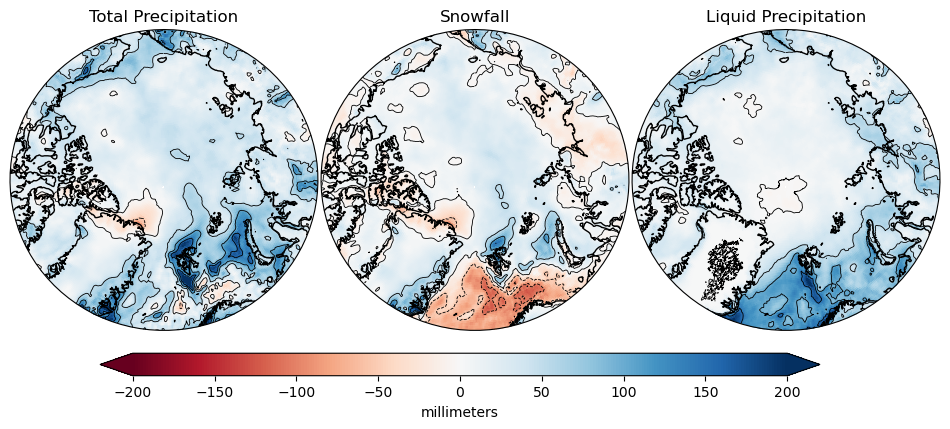

In [17]:
fig, axes = plt.subplots(
    nrows=1, 
    ncols=3, 
    figsize=(12,4.5),
    subplot_kw=dict(projection=PROJECTION)
)

vmin = -200
vmax = 200
cmap = "RdBu"
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

for ax, var in zip(axes, ["tp", "sf", "lp"]):
    plot_map(
        difference[var],
        ax=ax,
        contours=np.arange(vmin,vmax,50.),
        cmap=cmap,
        norm=norm,
        add_colorbar=False,
        title=f"{ds_ssn_clm[var].attrs["long_name"].title()}"
)

fig.subplots_adjust(bottom=0.05, wspace=0.01)
cax = fig.add_axes((0.2, 0.03, 0.6, 0.05))
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), 
             cax=cax, orientation="horizontal", 
             label="millimeters", extend="both")
